In [290]:
import os
import sys
import importlib
import pandas as pd
from datetime import date, timedelta
from dateutil.relativedelta import relativedelta
import matplotlib.pyplot as plt

import Data_Sourcing_v1
importlib.reload(Data_Sourcing_v1)
from Data_Sourcing_v1 import download_data

import Data_Sourcing_DBnomics_v1
importlib.reload(Data_Sourcing_DBnomics_v1)
from Data_Sourcing_DBnomics_v1 import dbnomics_download

import Data_Sourcing_Yfinance_v1
importlib.reload(Data_Sourcing_Yfinance_v1)
from Data_Sourcing_Yfinance_v1 import download_data_yfinance


In [291]:
print(os.getcwd())
print(sys.executable)

c:\Users\jerem\Documents\GitHub\Nowcasting-the-Business-Cycle
C:\Users\jerem\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe


In [292]:
df1, df2 = dbnomics_download()
ISM = pd.DataFrame()
ISM['manufacturing'] = df1['value']
ISM['non manufacturing'] =df2['value']
ISM = ISM.set_index(df1['period'])

ISM['Manufacturing delta neutral'] = (50 - ISM['manufacturing'])/ 50
ISM['Non manufacturing delta neutral'] = (50 - ISM['non manufacturing'])/50

  @frequency provider_code dataset_code         dataset_name series_code  \
0    monthly           ISM          pmi  Manufacturing - PMI          pm   
1    monthly           ISM          pmi  Manufacturing - PMI          pm   
2    monthly           ISM          pmi  Manufacturing - PMI          pm   
3    monthly           ISM          pmi  Manufacturing - PMI          pm   
4    monthly           ISM          pmi  Manufacturing - PMI          pm   

  series_name original_period     period  original_value  value frequency  \
0         PMI         2020-05 2020-05-01            43.1   43.1         M   
1         PMI         2020-06 2020-06-01            52.2   52.2         M   
2         PMI         2020-07 2020-07-01            53.7   53.7         M   
3         PMI         2020-08 2020-08-01            55.6   55.6         M   
4         PMI         2020-09 2020-09-01            55.7   55.7         M   

  Frequency  
0   Monthly  
1   Monthly  
2   Monthly  
3   Monthly  
4   Monthl

In [293]:
# define the tickers necessary for the dashboards

Markets = ['SP500', 'GS10','TB3MS', 'DBAA', 'DAAA','BAMLH0A0HYM2','DCOILWTICO']
stock_market = ['SP500']
yield_curve = ['T10Y3M','GS10','TB3MS']
credit_spreads = ['DBAA', 'DAAA','BAMLH0A0HYM2EY']
labour_market = ['USPRIV','ICSA','UNEMPLOY', 'CE16OV', 'AWHI']
consumer_spending = ['PCEC96','RRSFS','UMCSENT', 'W875RX1', 'PCE', 'PCEPI', 'RSXFS']
business_activity = ['INDPRO', 'CMRMTSPL']
oil = ['DCOILWTICO']
monetary_base = ['BOGMBASE','CPIAUCSL']
housing = ['PERMIT']


end_date = date.today() - timedelta(days = 1)
start_date = end_date - relativedelta(years = 35)
print(f'data begins at {start_date} and ends at date {end_date}')


(yield_curve_data,
  yield_curve_data_averages) = download_data(yield_curve, start_date, end_date)

(credit_spread_data,
  credit_spread_data_averages) = download_data(credit_spreads, start_date, end_date)

(labour_market_data,
  labour_market_data_averages) = download_data(labour_market, start_date, end_date)

(consumer_spending_data,
  consumer_spending_data_averages) = download_data(consumer_spending, start_date, end_date)

(business_activity_data,
  business_activity_data_averages) = download_data(business_activity, start_date, end_date)

(oil_data,
  oil_data_averages) = download_data(oil, start_date, end_date)

(monetary_base_data,
  monetary_base_data_averages) = download_data(monetary_base, start_date, end_date)

(housing_data,
  housing_data_averages) = download_data(housing, start_date, end_date)


data begins at 1989-10-29 and ends at date 2024-10-29
FREQUENCY OF TICKER:
T10Y3M : Daily


c:\Users\jerem\Documents\GitHub\Nowcasting-the-Business-Cycle\Data_Sourcing_v1.py:29: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_avg_dict[tick] = data_dict[tick].resample('M').mean()


FREQUENCY OF TICKER:
GS10 : Monthly
FREQUENCY OF TICKER:
TB3MS : Monthly
FREQUENCY OF TICKER:
DBAA : Daily


c:\Users\jerem\Documents\GitHub\Nowcasting-the-Business-Cycle\Data_Sourcing_v1.py:29: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_avg_dict[tick] = data_dict[tick].resample('M').mean()


FREQUENCY OF TICKER:
DAAA : Daily
FREQUENCY OF TICKER:
BAMLH0A0HYM2EY : Daily, Close
FREQUENCY OF TICKER:
USPRIV : Monthly
FREQUENCY OF TICKER:
ICSA : Weekly, Ending Saturday


c:\Users\jerem\Documents\GitHub\Nowcasting-the-Business-Cycle\Data_Sourcing_v1.py:32: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_avg_dict[tick] = data_dict[tick].resample('M').mean()


FREQUENCY OF TICKER:
UNEMPLOY : Monthly
FREQUENCY OF TICKER:
CE16OV : Monthly
FREQUENCY OF TICKER:
AWHI : Monthly
FREQUENCY OF TICKER:
PCEC96 : Monthly
FREQUENCY OF TICKER:
RRSFS : Monthly
FREQUENCY OF TICKER:
UMCSENT : Monthly
FREQUENCY OF TICKER:
W875RX1 : Monthly
FREQUENCY OF TICKER:
PCE : Monthly
FREQUENCY OF TICKER:
PCEPI : Monthly
FREQUENCY OF TICKER:
RSXFS : Monthly
FREQUENCY OF TICKER:
INDPRO : Monthly
FREQUENCY OF TICKER:
CMRMTSPL : Monthly
FREQUENCY OF TICKER:
DCOILWTICO : Daily


c:\Users\jerem\Documents\GitHub\Nowcasting-the-Business-Cycle\Data_Sourcing_v1.py:29: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_avg_dict[tick] = data_dict[tick].resample('M').mean()


FREQUENCY OF TICKER:
BOGMBASE : Monthly
FREQUENCY OF TICKER:
CPIAUCSL : Monthly
FREQUENCY OF TICKER:
PERMIT : Monthly


In [294]:
# download sp500 data using yfinance
stock_market = "^GSPC"

(stock_market_data,
  stock_market_data_averages) = download_data_yfinance(stock_market, start_date, end_date)

[*********************100%***********************]  1 of 1 completed
c:\Users\jerem\Documents\GitHub\Nowcasting-the-Business-Cycle\Data_Sourcing_Yfinance_v1.py:8: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_closing_prices = closing_prices.resample('M').mean()


<function matplotlib.pyplot.show(close=None, block=None)>

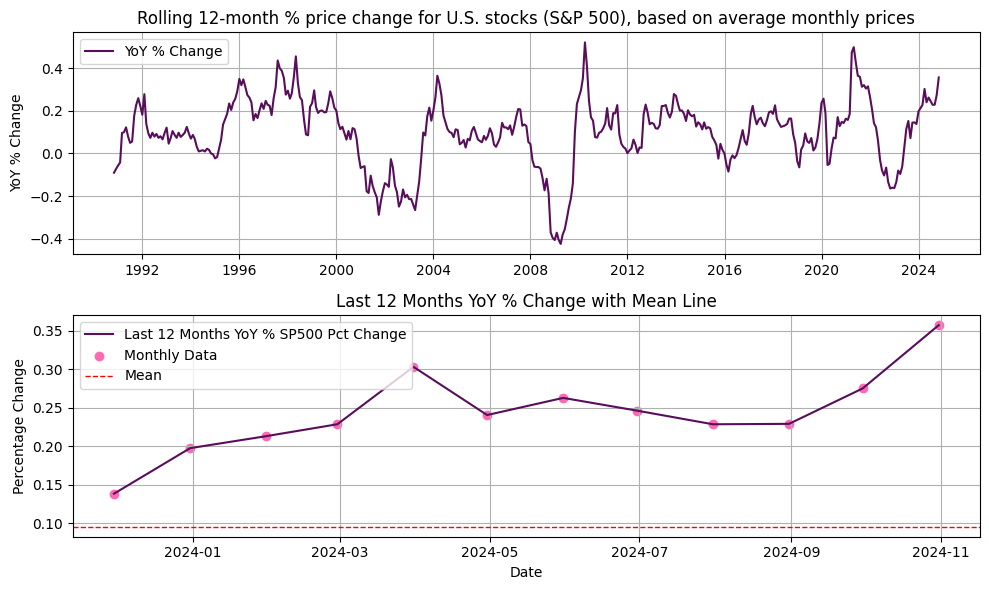

In [295]:
# focus on the Market data
year_delta_stock_market = stock_market_data_averages.pct_change(12)

fig, axs = plt.subplots(2,1, figsize = (10,6))

kkr_purple = '#590e5b'  # Approximate hex color from the KKR logo
marker_color = '#FF69B4'  # Another shade for the markers (pink)

# First subplot: Full year-over-year percentage change
axs[0].plot(year_delta_stock_market, color=kkr_purple, label="YoY % Change")
axs[0].set_title("Rolling 12-month % price change for U.S. stocks (S&P 500), based on average monthly prices")
axs[0].set_ylabel("YoY % Change")
axs[0].legend(loc="upper left")  # Add legend here with label
axs[0].grid(True)
# Second subplot: Last 12 months with mean line and markers
axs[1].plot(year_delta_stock_market.iloc[-12:], color=kkr_purple, label="Last 12 Months YoY % SP500 Pct Change")
axs[1].scatter(year_delta_stock_market.iloc[-12:].index, year_delta_stock_market.iloc[-12:], color=marker_color, label="Monthly Data")
axs[1].axhline(year_delta_stock_market.mean(), color='red', linestyle='--', linewidth=1, label="Mean")
axs[1].set_title("Last 12 Months YoY % Change with Mean Line")
axs[1].set_ylabel("Percentage Change")
axs[1].set_xlabel("Date")
axs[1].legend(loc="upper left")
axs[1].grid(True)

plt.tight_layout()
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

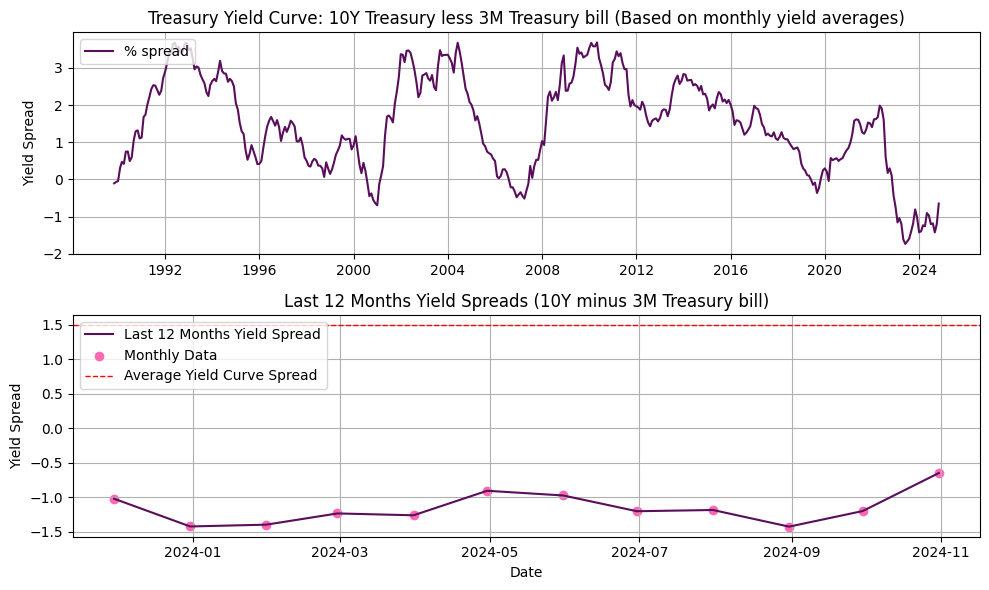

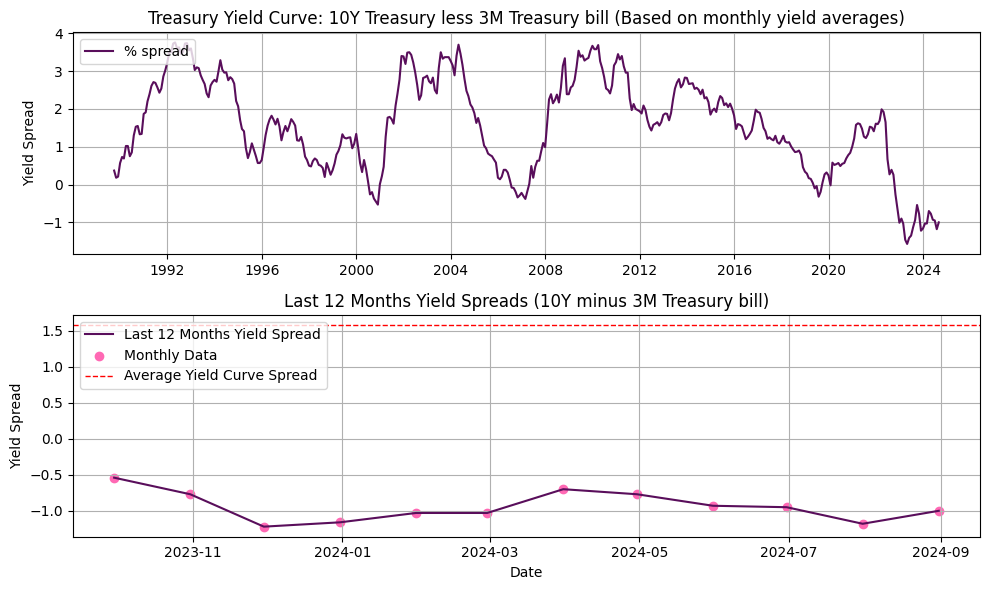

In [296]:

# Yield Spread analysis using T10Y3M provided by the FED database
fig, axs = plt.subplots(2,1, figsize = (10,6))

kkr_purple = '#590e5b'  # Approximate hex color from the KKR logo
marker_color = '#FF69B4'  # Another shade for the markers (pink)

# First subplot: Full year-over-year percentage change
axs[0].plot(yield_curve_data_averages['T10Y3M'], color=kkr_purple, label="% spread")
axs[0].set_title("Treasury Yield Curve: 10Y Treasury less 3M Treasury bill (Based on monthly yield averages)")
axs[0].set_ylabel("Yield Spread")
axs[0].legend(loc="upper left")  # Add legend here with label
axs[0].grid(True)
# Second subplot: Last 12 months with mean line and markers
axs[1].plot(yield_curve_data_averages['T10Y3M'].iloc[-12:], color=kkr_purple, label="Last 12 Months Yield Spread")
axs[1].scatter(yield_curve_data_averages['T10Y3M'].iloc[-12:].index, yield_curve_data_averages['T10Y3M'].iloc[-12:], color=marker_color, label="Monthly Data")
axs[1].axhline(yield_curve_data_averages['T10Y3M'].mean(), color='red', linestyle='--', linewidth=1, label="Average Yield Curve Spread")
axs[1].set_title("Last 12 Months Yield Spreads (10Y minus 3M Treasury bill)")
axs[1].set_ylabel("Yield Spread")
axs[1].set_xlabel("Date")
axs[1].legend(loc="upper left")
axs[1].grid(True)

plt.tight_layout()
plt.show


# Yield Spread analysis using individual yield time series as shown in Picerno

yield_spread = yield_curve_data['GS10'] - yield_curve_data['TB3MS']
yield_spread.dropna(inplace = True)

# Yield Spread analysis using T10Y3M provided by the FED database
fig, axs = plt.subplots(2,1, figsize = (10,6))

# First subplot: Full year-over-year percentage change
axs[0].plot(yield_spread, color=kkr_purple, label="% spread")
axs[0].set_title("Treasury Yield Curve: 10Y Treasury less 3M Treasury bill (Based on monthly yield averages)")
axs[0].set_ylabel("Yield Spread")
axs[0].legend(loc="upper left")  # Add legend here with label
axs[0].grid(True)
# Second subplot: Last 12 months with mean line and markers
axs[1].plot(yield_spread.iloc[-12:], color=kkr_purple, label="Last 12 Months Yield Spread")
axs[1].scatter(yield_spread.iloc[-12:].index, yield_spread.iloc[-12:], color=marker_color, label="Monthly Data")
axs[1].axhline(yield_spread.mean(), color='red', linestyle='--', linewidth=1, label="Average Yield Curve Spread")
axs[1].set_title("Last 12 Months Yield Spreads (10Y minus 3M Treasury bill)")
axs[1].set_ylabel("Yield Spread")
axs[1].set_xlabel("Date")
axs[1].legend(loc="upper left")
axs[1].grid(True)

plt.tight_layout()
plt.show



C:\Users\jerem\AppData\Local\Temp\ipykernel_30088\3192304299.py:6: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  avg_Baa_Aaa_spread = Baa_Aaa_spread.resample('M').mean()
C:\Users\jerem\AppData\Local\Temp\ipykernel_30088\3192304299.py:40: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  avg_HY_spread = HY_Aaa_spread.resample('M').mean()


<function matplotlib.pyplot.show(close=None, block=None)>

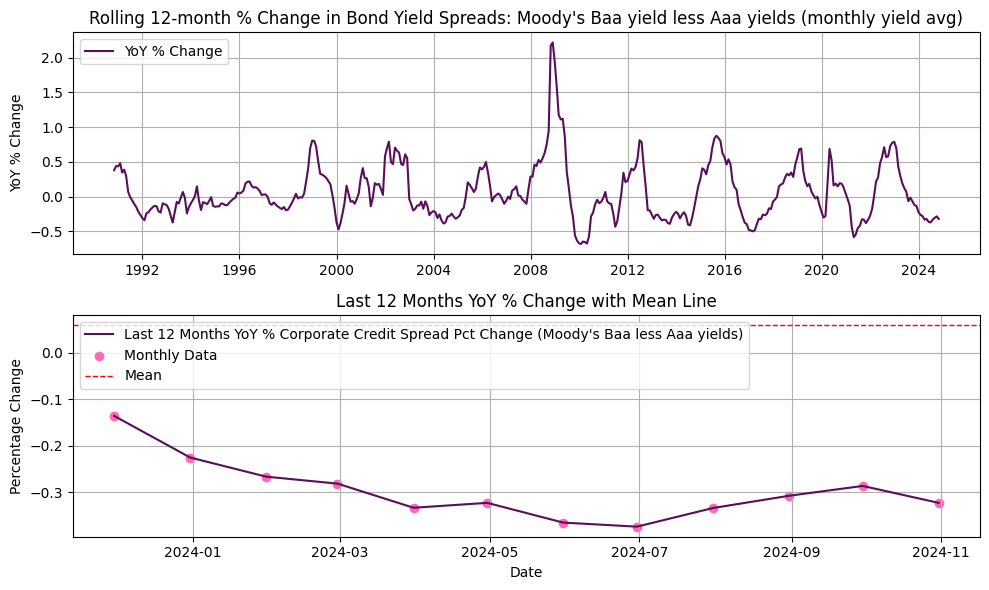

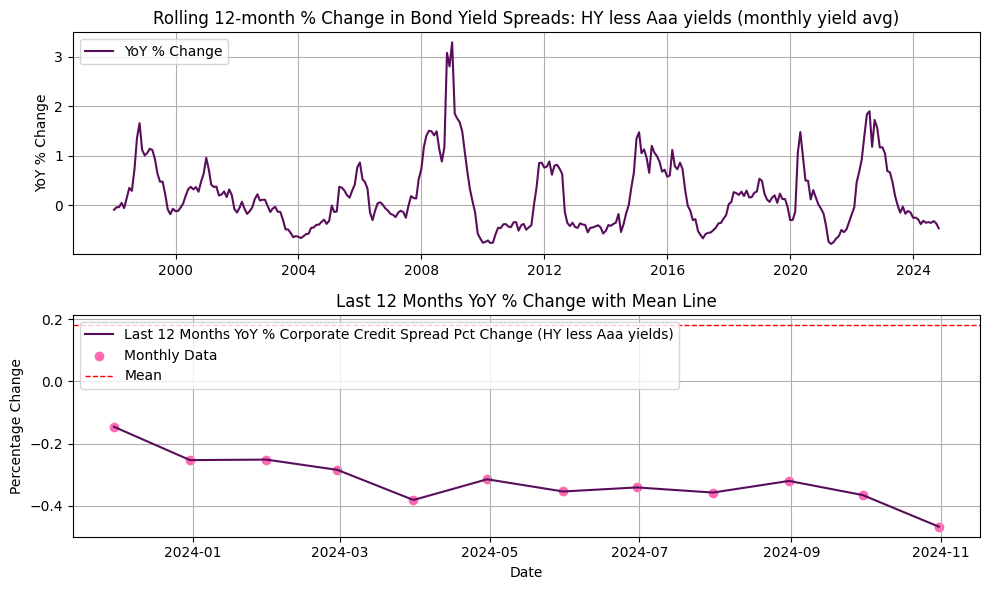

In [ ]:
# Credit Spreads

# First we use the AAA - BAA spread

Baa_Aaa_spread = credit_spread_data['DBAA'] - credit_spread_data['DAAA']
avg_Baa_Aaa_spread = Baa_Aaa_spread.resample('M').mean()
year_delta_credit_spread = avg_Baa_Aaa_spread.pct_change(12)
year_delta_credit_spread.dropna(inplace = True)
year_delta_credit_spread.name = 'Credit spread'


fig, axs = plt.subplots(2,1, figsize = (10,6))

kkr_purple = '#590e5b'  # Approximate hex color from the KKR logo
marker_color = '#FF69B4'  # Another shade for the markers (pink)

# First subplot: Full year-over-year percentage change
axs[0].plot(year_delta_credit_spread, color=kkr_purple, label="YoY % Change")
axs[0].set_title("Rolling 12-month % Change in Bond Yield Spreads: Moody's Baa yield less Aaa yields (monthly yield avg)")
axs[0].set_ylabel("YoY % Change")
axs[0].legend(loc="upper left")  # Add legend here with label
axs[0].grid(True)
# Second subplot: Last 12 months with mean line and markers
axs[1].plot(year_delta_credit_spread.iloc[-12:], color=kkr_purple, label="Last 12 Months YoY % Corporate Credit Spread Pct Change (Moody's Baa less Aaa yields)")
axs[1].scatter(year_delta_credit_spread.iloc[-12:].index, year_delta_credit_spread.iloc[-12:], color=marker_color, label="Monthly Data")
axs[1].axhline(year_delta_credit_spread.mean(), color='red', linestyle='--', linewidth=1, label="Mean")
axs[1].set_title("Last 12 Months YoY % Change with Mean Line")
axs[1].set_ylabel("Percentage Change")
axs[1].set_xlabel("Date")
axs[1].legend(loc="upper left")
axs[1].grid(True)

plt.tight_layout()
plt.show


# Using BoFa Meryl Lynch junk bond data

HY_Aaa_spread = credit_spread_data['BAMLH0A0HYM2EY'] - credit_spread_data['DAAA']
HY_Aaa_spread.dropna(inplace = True)
avg_HY_spread = HY_Aaa_spread.resample('M').mean()
year_delta_HY_spread = avg_HY_spread.pct_change(12)


fig, axs = plt.subplots(2,1, figsize = (10,6))

# First subplot: Full year-over-year percentage change
axs[0].plot(year_delta_HY_spread, color=kkr_purple, label="YoY % Change")
axs[0].set_title("Rolling 12-month % Change in Bond Yield Spreads: HY less Aaa yields (monthly yield avg)")
axs[0].set_ylabel("YoY % Change")
axs[0].legend(loc="upper left")  # Add legend here with label
axs[0].grid(True)
# Second subplot: Last 12 months with mean line and markers
axs[1].plot(year_delta_HY_spread.iloc[-12:], color=kkr_purple, label="Last 12 Months YoY % Corporate Credit Spread Pct Change (HY less Aaa yields)")
axs[1].scatter(year_delta_HY_spread.iloc[-12:].index, year_delta_HY_spread.iloc[-12:], color=marker_color, label="Monthly Data")
axs[1].axhline(year_delta_HY_spread.mean(), color='red', linestyle='--', linewidth=1, label="Mean")
axs[1].set_title("Last 12 Months YoY % Change with Mean Line")
axs[1].set_ylabel("Percentage Change")
axs[1].set_xlabel("Date")
axs[1].legend(loc="upper left")
axs[1].grid(True)

plt.tight_layout()
plt.show


C:\Users\jerem\AppData\Local\Temp\ipykernel_30088\2899785028.py:5: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  labour_market_data_averages['employment_ratio'] = labour_market_data['employment_ratio'].resample('M').mean()
C:\Users\jerem\AppData\Local\Temp\ipykernel_30088\2899785028.py:6: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  year_delta_labour_market = labour_market_data_averages.pct_change(12)


<function matplotlib.pyplot.show(close=None, block=None)>

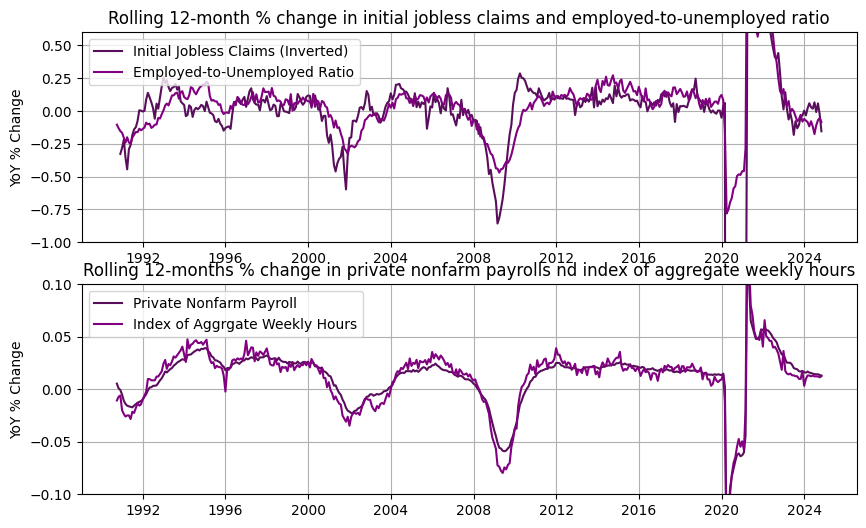

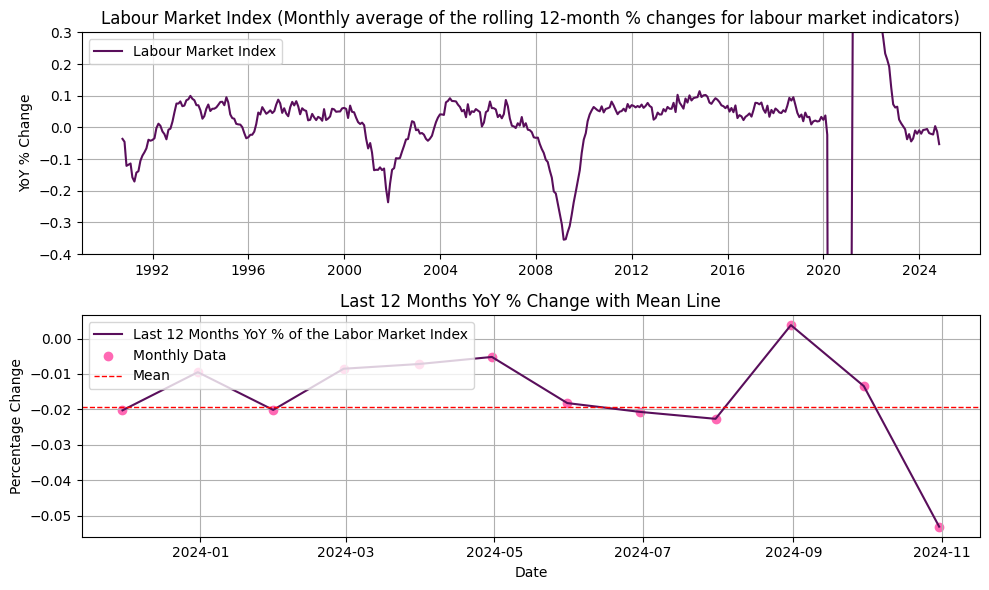

In [298]:
# labour market

# build the labour market index
labour_market_data['employment_ratio'] = labour_market_data['CE16OV'] / labour_market_data['UNEMPLOY']
labour_market_data_averages['employment_ratio'] = labour_market_data['employment_ratio'].resample('M').mean() 
year_delta_labour_market = labour_market_data_averages.pct_change(12)
year_delta_labour_market['ICSA'] = year_delta_labour_market['ICSA'] * -1 

labour_market_index = year_delta_labour_market[['ICSA', 'employment_ratio', 'USPRIV', 'AWHI']].mean(axis = 1)

# plot the constituents of the Labour market index

fig, axs = plt.subplots(2,1, figsize = (10,6))

# First subplot: Full year-over-year percentage change
axs[0].plot(year_delta_labour_market['ICSA'], color=kkr_purple, label="Initial Jobless Claims (Inverted)")
axs[0].plot(year_delta_labour_market['employment_ratio'], color= 'purple', label="Employed-to-Unemployed Ratio")
axs[0].set_title("Rolling 12-month % change in initial jobless claims and employed-to-unemployed ratio")
axs[0].set_ylabel("YoY % Change")
axs[0].legend(loc="upper left")  # Add legend here with label
axs[0].grid(True)
axs[0].set_ylim(-1, 0.6)

axs[1].plot(year_delta_labour_market['USPRIV'], color=kkr_purple, label="Private Nonfarm Payroll")
axs[1].plot(year_delta_labour_market['AWHI'], color='purple', label="Index of Aggrgate Weekly Hours")
axs[1].set_title("Rolling 12-months % change in private nonfarm payrolls nd index of aggregate weekly hours")
axs[1].set_ylabel("YoY % Change")
axs[1].legend(loc="upper left")  # Add legend here with label
axs[1].grid(True)
axs[1].set_ylim(-0.1, 0.1)

fig, axs = plt.subplots(2,1, figsize = (10,6))

# First subplot: Full year-over-year percentage change
axs[0].plot(labour_market_index, color=kkr_purple, label="Labour Market Index")
axs[0].set_title("Labour Market Index (Monthly average of the rolling 12-month % changes for labour market indicators)")
axs[0].set_ylabel("YoY % Change")
axs[0].legend(loc="upper left")  # Add legend here with label
axs[0].grid(True)
axs[0].set_ylim(-0.4,0.3)
# Second subplot: Last 12 months with mean line and markers
axs[1].plot(labour_market_index.iloc[-12:], color=kkr_purple, label="Last 12 Months YoY % of the Labor Market Index")
axs[1].scatter(labour_market_index.iloc[-12:].index, labour_market_index.iloc[-12:], color=marker_color, label="Monthly Data")
axs[1].axhline(labour_market_index.mean(), color='red', linestyle='--', linewidth=1, label="Mean")
axs[1].set_title("Last 12 Months YoY % Change with Mean Line")
axs[1].set_ylabel("Percentage Change")
axs[1].set_xlabel("Date")
axs[1].legend(loc="upper left")
axs[1].grid(True)

plt.tight_layout()
plt.show



C:\Users\jerem\AppData\Local\Temp\ipykernel_30088\714120969.py:8: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  year_delta_consumer_spending = consumer_spending_data.pct_change(12)


<function matplotlib.pyplot.show(close=None, block=None)>

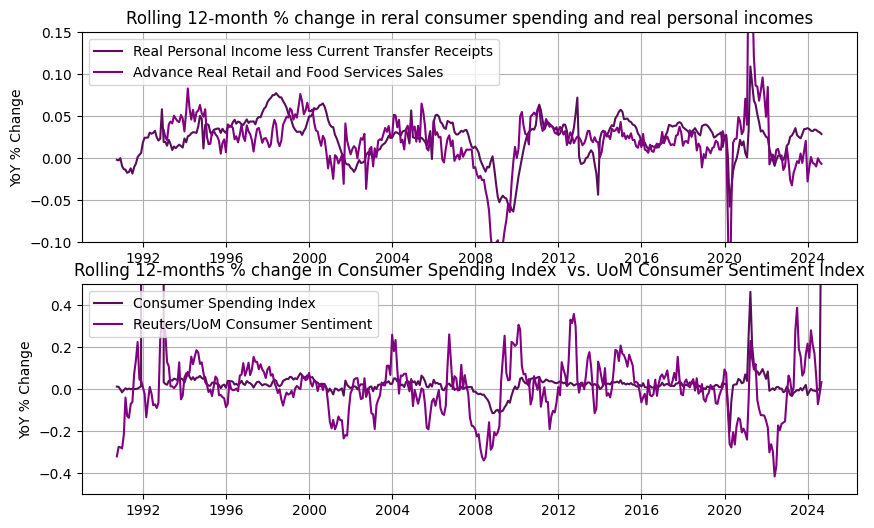

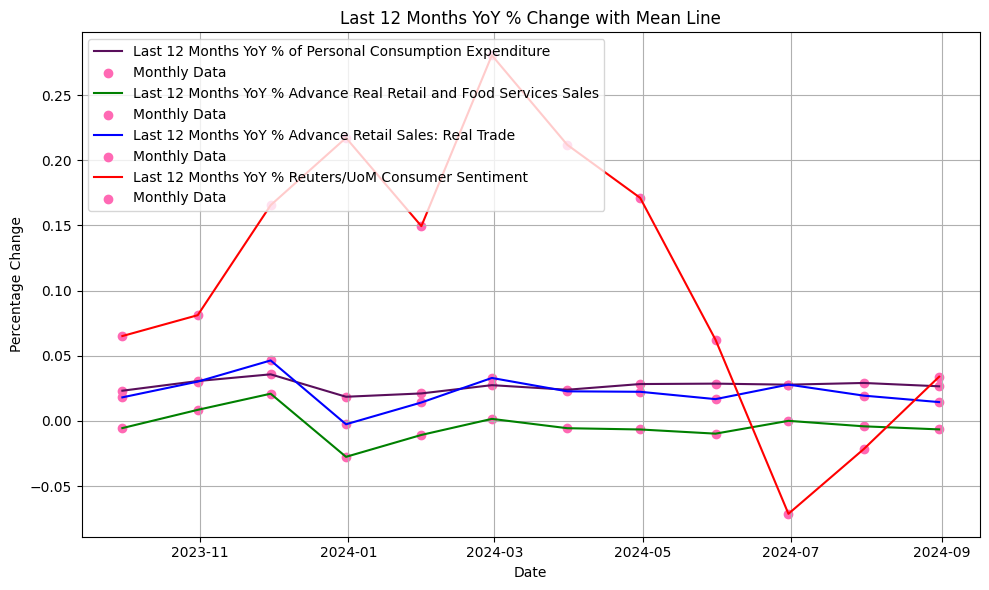

In [299]:
# Consumer Spending
# Lets build the consumer spendig index

consumer_spending_data['personal_consumption_expenditure'] = consumer_spending_data['PCE'] / consumer_spending_data['PCEPI']
consumer_spending_data['consumer_spending_index'] = consumer_spending_data[['personal_consumption_expenditure', 'RSXFS']].mean(axis = 1)
consumer_spending_data['consumer_spending_index'] = consumer_spending_data[['personal_consumption_expenditure', 'RRSFS']].mean(axis = 1)

year_delta_consumer_spending = consumer_spending_data.pct_change(12)

#Lets first look at the relationship between the change between consumption and CSI


fig, axs = plt.subplots(2,1, figsize = (10,6))

# First subplot: Full year-over-year percentage change
axs[0].plot(year_delta_consumer_spending['W875RX1'], color=kkr_purple, label="Real Personal Income less Current Transfer Receipts")
axs[0].plot(year_delta_consumer_spending['RRSFS'], color= 'purple', label="Advance Real Retail and Food Services Sales")
axs[0].set_title("Rolling 12-month % change in reral consumer spending and real personal incomes")
axs[0].set_ylabel("YoY % Change")
axs[0].legend(loc="upper left")  # Add legend here with label
axs[0].grid(True)
axs[0].set_ylim(-0.1, 0.15)

axs[1].plot(year_delta_consumer_spending['consumer_spending_index'], color=kkr_purple, label="Consumer Spending Index")
axs[1].plot(year_delta_consumer_spending['UMCSENT'], color='purple', label="Reuters/UoM Consumer Sentiment")
axs[1].set_title("Rolling 12-months % change in Consumer Spending Index  vs. UoM Consumer Sentiment Index")
axs[1].set_ylabel("YoY % Change")
axs[1].legend(loc="upper left")  # Add legend here with label
axs[1].grid(True)
axs[1].set_ylim(-0.5, 0.5)



fig, axs = plt.subplots(1,1, figsize = (10,6))


# Second subplot: Last 12 months with mean line and markers
axs.plot(year_delta_consumer_spending['personal_consumption_expenditure'].iloc[-12:], color=kkr_purple, label="Last 12 Months YoY % of Personal Consumption Expenditure")
axs.scatter(year_delta_consumer_spending['personal_consumption_expenditure'].iloc[-12:].index, year_delta_consumer_spending['personal_consumption_expenditure'].iloc[-12:], color=marker_color, label="Monthly Data")

axs.plot(year_delta_consumer_spending['RRSFS'].iloc[-12:], color='green', label="Last 12 Months YoY % Advance Real Retail and Food Services Sales")
axs.scatter(year_delta_consumer_spending['RRSFS'].iloc[-12:].index, year_delta_consumer_spending['RRSFS'].iloc[-12:], color=marker_color, label="Monthly Data")

axs.plot(year_delta_consumer_spending['RSXFS'].iloc[-12:], color='blue', label="Last 12 Months YoY % Advance Retail Sales: Real Trade")
axs.scatter(year_delta_consumer_spending['RSXFS'].iloc[-12:].index, year_delta_consumer_spending['RSXFS'].iloc[-12:], color=marker_color, label="Monthly Data")

axs.plot(year_delta_consumer_spending['UMCSENT'].iloc[-12:], color='red', label="Last 12 Months YoY % Reuters/UoM Consumer Sentiment")
axs.scatter(year_delta_consumer_spending['UMCSENT'].iloc[-12:].index, year_delta_consumer_spending['UMCSENT'].iloc[-12:], color=marker_color, label="Monthly Data")


#axs[0].axhline(labour_market_index.mean(), color='red', linestyle='--', linewidth=1, label="Mean")
axs.set_title("Last 12 Months YoY % Change with Mean Line")
axs.set_ylabel("Percentage Change")
axs.set_xlabel("Date")
axs.legend(loc="upper left")
axs.grid(True)

plt.tight_layout()
plt.show

C:\Users\jerem\AppData\Local\Temp\ipykernel_30088\213732842.py:3: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  year_delta_business_activity = business_activity_data.pct_change(12)


<function matplotlib.pyplot.show(close=None, block=None)>

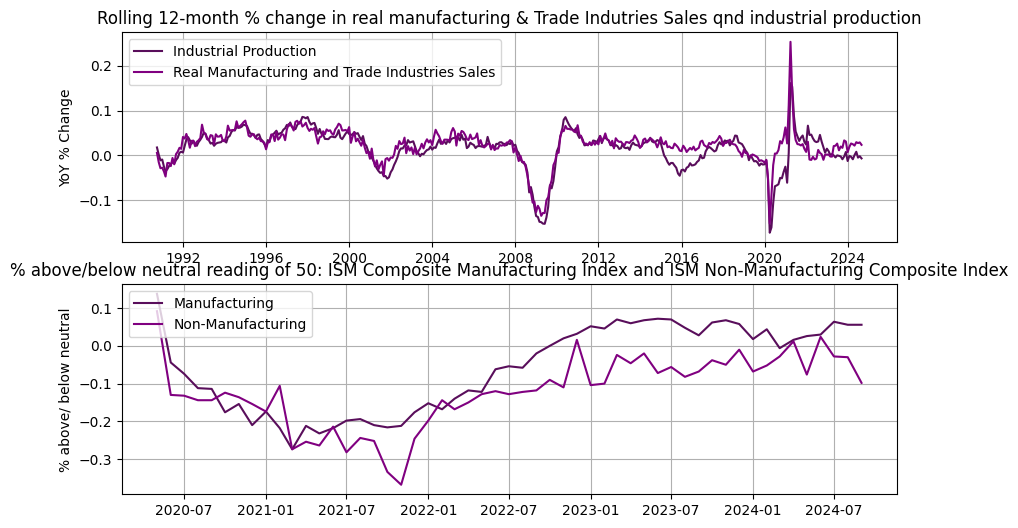

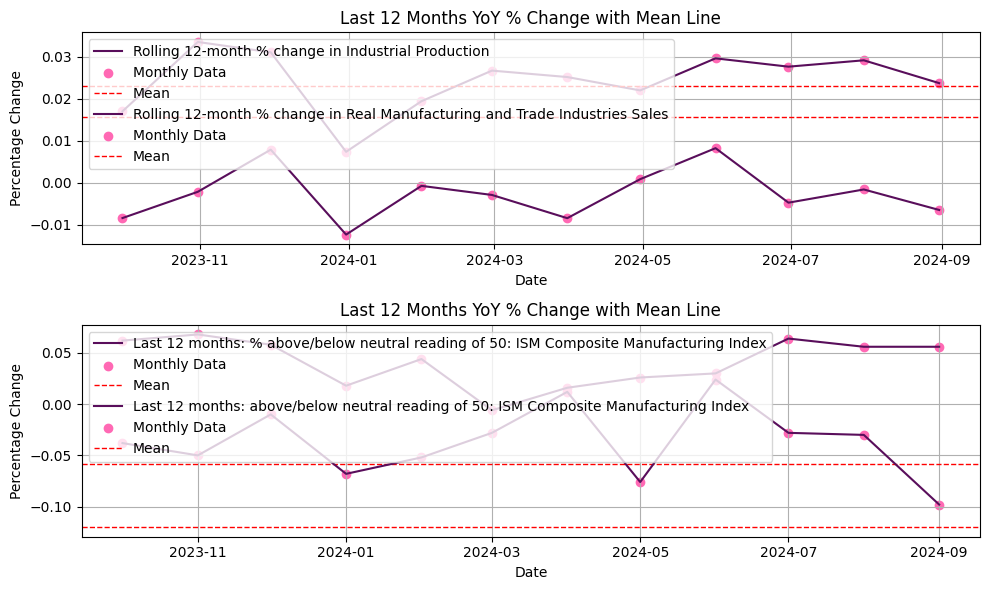

In [300]:
# business spending

year_delta_business_activity = business_activity_data.pct_change(12)


fig, axs = plt.subplots(2,1, figsize = (10,6))

# First subplot: Full year-over-year percentage change
axs[0].plot(year_delta_business_activity['INDPRO'], color=kkr_purple, label="Industrial Production")
axs[0].plot(year_delta_business_activity['CMRMTSPL'], color= 'purple', label="Real Manufacturing and Trade Industries Sales")
axs[0].set_title("Rolling 12-month % change in real manufacturing & Trade Indutries Sales qnd industrial production")
axs[0].set_ylabel("YoY % Change")
axs[0].legend(loc="upper left")  # Add legend here with label
axs[0].grid(True)
#axs[0].set_ylim(-0.1, 0.15)

# First subplot: Full year-over-year percentage change
axs[1].plot(ISM['Manufacturing delta neutral'], color=kkr_purple, label="Manufacturing")
axs[1].plot(ISM['Non manufacturing delta neutral'], color= 'purple', label="Non-Manufacturing")
axs[1].set_title("% above/below neutral reading of 50: ISM Composite Manufacturing Index and ISM Non-Manufacturing Composite Index")
axs[1].set_ylabel("% above/ below neutral")
axs[1].legend(loc="upper left")  # Add legend here with label
axs[1].grid(True)
#axs[1].set_ylim(-0.1, 0.15)



fig, axs = plt.subplots(2,1, figsize = (10,6))

# Second subplot: Last 12 months with mean line and markers
axs[0].plot(year_delta_business_activity['INDPRO'].iloc[-12:], color=kkr_purple, label="Rolling 12-month % change in Industrial Production")
axs[0].scatter(year_delta_business_activity['INDPRO'].iloc[-12:].index, year_delta_business_activity['INDPRO'].iloc[-12:], color=marker_color, label="Monthly Data")
axs[0].axhline(year_delta_business_activity['INDPRO'].mean(), color='red', linestyle='--', linewidth=1, label="Mean")

axs[0].plot(year_delta_business_activity['CMRMTSPL'].iloc[-12:], color=kkr_purple, label="Rolling 12-month % change in Real Manufacturing and Trade Industries Sales")
axs[0].scatter(year_delta_business_activity['CMRMTSPL'].iloc[-12:].index, year_delta_business_activity['CMRMTSPL'].iloc[-12:], color=marker_color, label="Monthly Data")
axs[0].axhline(year_delta_business_activity['CMRMTSPL'].mean(), color='red', linestyle='--', linewidth=1, label="Mean")


axs[0].set_title("Last 12 Months YoY % Change with Mean Line")
axs[0].set_ylabel("Percentage Change")
axs[0].set_xlabel("Date")
axs[0].legend(loc="upper left")
axs[0].grid(True)


axs[1].plot(ISM['Manufacturing delta neutral'].iloc[-12:], color=kkr_purple, label="Last 12 months: % above/below neutral reading of 50: ISM Composite Manufacturing Index")
axs[1].scatter(ISM['Manufacturing delta neutral'].iloc[-12:].index,ISM['Manufacturing delta neutral'].iloc[-12:], color=marker_color, label="Monthly Data")
axs[1].axhline(ISM['Manufacturing delta neutral'].mean(), color='red', linestyle='--', linewidth=1, label="Mean")

axs[1].plot(ISM['Non manufacturing delta neutral'].iloc[-12:], color=kkr_purple, label="Last 12 months: above/below neutral reading of 50: ISM Composite Manufacturing Index")
axs[1].scatter(ISM['Non manufacturing delta neutral'].iloc[-12:].index,ISM['Non manufacturing delta neutral'].iloc[-12:], color=marker_color, label="Monthly Data")
axs[1].axhline(ISM['Non manufacturing delta neutral'].mean(), color='red', linestyle='--', linewidth=1, label="Mean")

axs[1].set_title("Last 12 Months YoY % Change with Mean Line")
axs[1].set_ylabel("Percentage Change")
axs[1].set_xlabel("Date")
axs[1].legend(loc="upper left")
axs[1].grid(True)


plt.tight_layout()
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

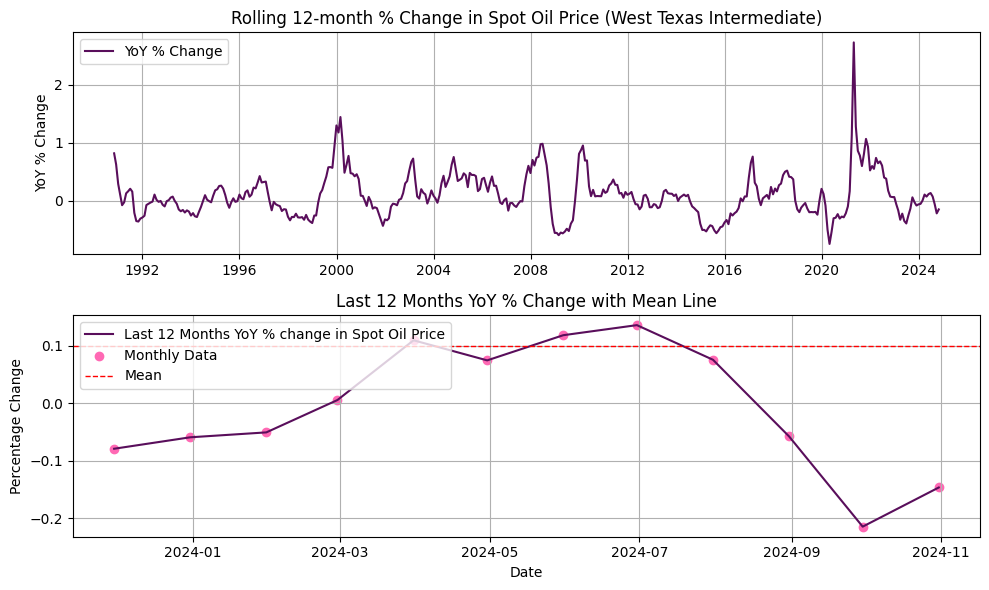

In [301]:
#oil
year_delta_oil = oil_data_averages.pct_change(12)

fig, axs = plt.subplots(2,1, figsize = (10,6))

# First subplot: Full year-over-year percentage change
axs[0].plot(year_delta_oil, color=kkr_purple, label="YoY % Change")
axs[0].set_title("Rolling 12-month % Change in Spot Oil Price (West Texas Intermediate)")
axs[0].set_ylabel("YoY % Change")
axs[0].legend(loc="upper left")  # Add legend here with label
axs[0].grid(True)
# Second subplot: Last 12 months with mean line and markers
axs[1].plot(year_delta_oil.iloc[-12:], color=kkr_purple, label="Last 12 Months YoY % change in Spot Oil Price")
axs[1].scatter(year_delta_oil.iloc[-12:].index, year_delta_oil.iloc[-12:], color=marker_color, label="Monthly Data")
axs[1].axhline(year_delta_oil['DCOILWTICO'].mean(), color='red', linestyle='--', linewidth=1, label="Mean")
axs[1].set_title("Last 12 Months YoY % Change with Mean Line")
axs[1].set_ylabel("Percentage Change")
axs[1].set_xlabel("Date")
axs[1].legend(loc="upper left")
axs[1].grid(True)

plt.tight_layout()
plt.show



<function matplotlib.pyplot.show(close=None, block=None)>

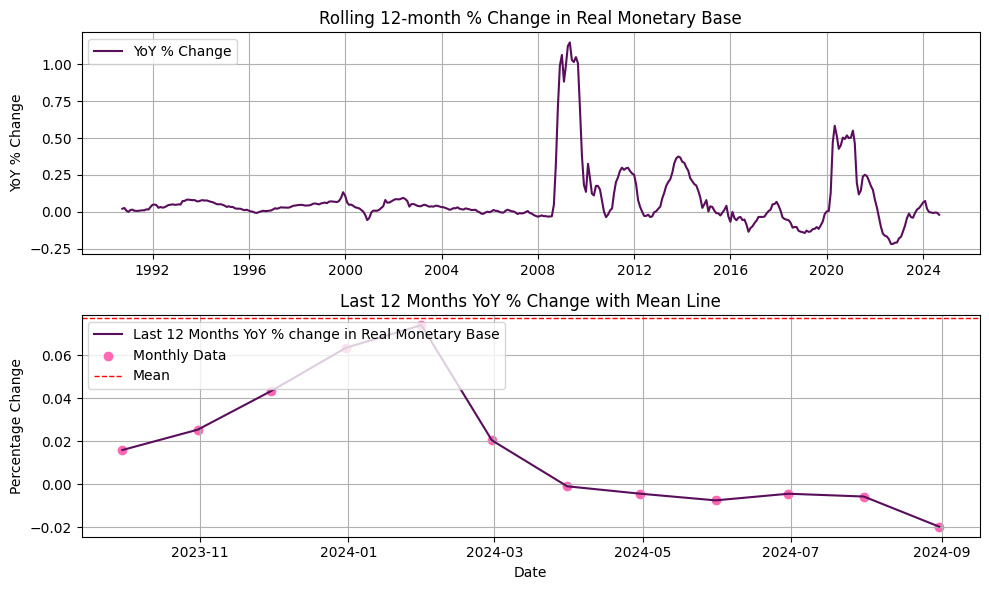

In [302]:
# Money Supply
monetary_base_data_averages['real monetary base'] = monetary_base_data_averages['BOGMBASE'] / monetary_base_data_averages['CPIAUCSL']
year_delta_monetary_base = monetary_base_data_averages.pct_change(12)


fig, axs = plt.subplots(2,1, figsize = (10,6))

# First subplot: Full year-over-year percentage change
axs[0].plot(year_delta_monetary_base['real monetary base'], color=kkr_purple, label="YoY % Change")
axs[0].set_title("Rolling 12-month % Change in Real Monetary Base")
axs[0].set_ylabel("YoY % Change")
axs[0].legend(loc="upper left")  # Add legend here with label
axs[0].grid(True)
# Second subplot: Last 12 months with mean line and markers
axs[1].plot(year_delta_monetary_base['real monetary base'].iloc[-12:], color=kkr_purple, label="Last 12 Months YoY % change in Real Monetary Base")
axs[1].scatter(year_delta_monetary_base['real monetary base'].iloc[-12:].index, year_delta_monetary_base['real monetary base'].iloc[-12:], color=marker_color, label="Monthly Data")
axs[1].axhline(year_delta_monetary_base['real monetary base'].mean(), color='red', linestyle='--', linewidth=1, label="Mean")
axs[1].set_title("Last 12 Months YoY % Change with Mean Line")
axs[1].set_ylabel("Percentage Change")
axs[1].set_xlabel("Date")
axs[1].legend(loc="upper left")
axs[1].grid(True)

plt.tight_layout()
plt.show



<function matplotlib.pyplot.show(close=None, block=None)>

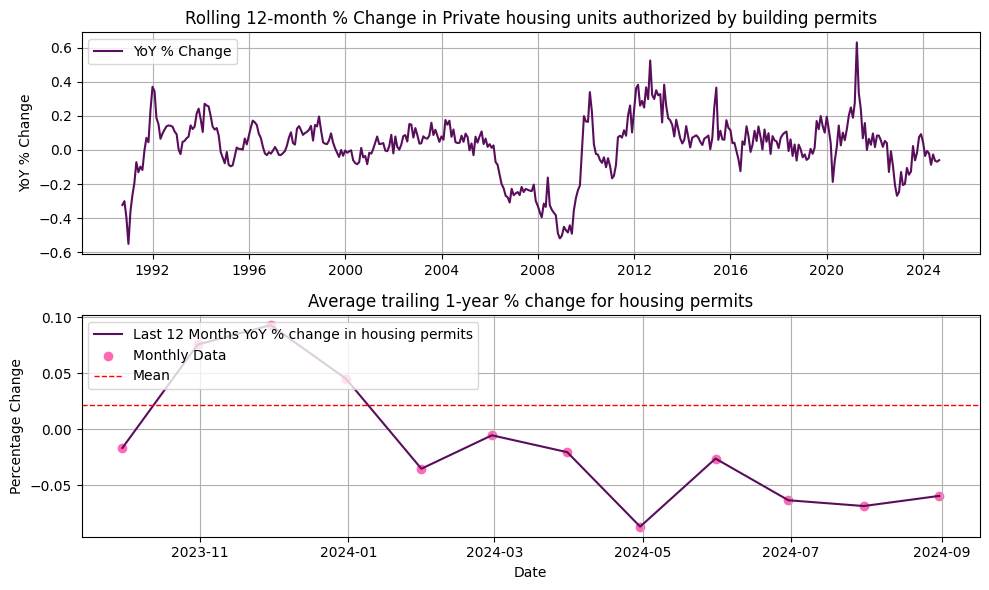

In [303]:
# housing market

year_delta_housing = housing_data_averages.pct_change(12)


fig, axs = plt.subplots(2,1, figsize = (10,6))

# First subplot: Full year-over-year percentage change
axs[0].plot(year_delta_housing, color=kkr_purple, label="YoY % Change")
axs[0].set_title("Rolling 12-month % Change in Private housing units authorized by building permits")
axs[0].set_ylabel("YoY % Change")
axs[0].legend(loc="upper left")  # Add legend here with label
axs[0].grid(True)

# Second subplot: Last 12 months with mean line and markers
axs[1].plot(year_delta_housing.iloc[-12:], color=kkr_purple, label="Last 12 Months YoY % change in housing permits")
axs[1].scatter(year_delta_housing.iloc[-12:].index, year_delta_housing.iloc[-12:], color=marker_color, label="Monthly Data")
axs[1].axhline(year_delta_housing['PERMIT'].mean(), color='red', linestyle='--', linewidth=1, label="Mean")
axs[1].set_title("Average trailing 1-year % change for housing permits")
axs[1].set_ylabel("Percentage Change")
axs[1].set_xlabel("Date")
axs[1].legend(loc="upper left")
axs[1].grid(True)

plt.tight_layout()
plt.show


In [ ]:
# Combine all time series that were going to be using for the 

indicators = pd.concat([year_delta_stock_market['Close'], # Stock market YoY change , 421
                        yield_curve_data_averages['T10Y3M'][1:]/10, # Yield curve % spread (multiplied by 10), 422
                        year_delta_credit_spread, # Credit Spread YoY change
                        ])